In [1]:
import time

import foolbox
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from tqdm import tqdm

import cv2

# pretrained model state_dict path
MODEL_PATH = 'resnet_imagenette.pth'

# 10 classes
CLASS_NAMES = ['tench', 'English springer', 'cassette player', 'chain saw', 'church',
               'French horn', 'garbage truck', 'gas pump', 'golf ball', 'parachute']

# instantiate model
model = torchvision.models.resnet18(pretrained=True)

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, len(CLASS_NAMES))

model.load_state_dict(torch.load(MODEL_PATH))
model.eval()

print('Instantiated ConvNET model: ResNet18ImageNette.')


Instantiated ConvNET model: ResNet18ImageNette.


In [2]:
# use GPU if available
if torch.cuda.is_available():
  model = model.cuda()

# instantiate Foolbox wrapper
preprocessing = dict(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225], axis=-3)

fmodel = foolbox.models.PyTorchModel(model, bounds=(0, 1),
                                     num_classes=10,
                                     preprocessing=preprocessing)

# load validation images
transform = transforms.Compose([
    transforms.Resize((213, 213)),
    transforms.ToTensor()
])

dataset_path = '../data/imagenette2-160/val'
dataset = torchvision.datasets.ImageFolder(
    root=dataset_path, transform=transform)

# indice at which each class starts: [0, 200, 400 ... 1800]
class_start_indice = [indice * 200 for indice in range(0, 10)]
# grab 10 images from each class: [0, 1, 2 ... 9, 200, 201, 202 ... 1800, 1801, 1802 ... 1809]
images_in_class_indice = np.array(
    [[j for j in range(k, k + 10)] for k in class_start_indice]).flatten()

# size of each batch
BATCH_SIZE = 4

# get 10 images from 10 classes for a total of 100 images
dataset = torch.utils.data.Subset(dataset, images_in_class_indice)
# compose dataset into dataloader
dataset_loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE)
dataset_size = len(dataset)

print('Loaded data from: {} with a total of {} images.'.format(
    dataset_path, dataset_size))


Loaded data from: ../data/imagenette2-160/val with a total of 100 images.


In [3]:
# Validate model's base prediction accuracy (about 97%)
# takes about 5 seconds on GPU
pbar = tqdm(dataset_loader)
pbar.set_description('Validate predictions')
pbar.set_postfix(acc='0.0%')

preds = []
acc = 0.0
for i, (image, label) in enumerate(pbar):
  # make a prediction
  prob = fmodel.forward(image.numpy())
  pred = np.argmax(prob, axis=-1)
  preds.append(pred)

  # calculate current accuracy
  acc += np.sum(pred == label.numpy())
  current_acc = acc * 100 / ((i + 1) * BATCH_SIZE)
  pbar.set_postfix(acc='{:.2f}%'.format(current_acc))

acc = acc * 100 / dataset_size
pbar.write('\nValidated with accuracy of: {:.2f}%'.format(acc))


Validate predictions: 100%|██████████| 25/25 [00:00<00:00, 27.56it/s, acc=97.00%] 


Validated with accuracy of: 97.00%


In [35]:
# Perform multiple attacks with different algorithms
#
# - FGSM: takes about 30s on GPU with attack effectiveness of 82%
# - DeepFool: takes about 3m on GPU with attack effectiveness of 93%
# - JSMA: takes about 49m on GPU
# - CW: takes about 3 hours on GPU
# - MI-FGSM: takes about 30m on GPU with attack effectiveness of 100%

# means_of_attack = ['FGSM', 'DeepFool', 'JSMA', 'CW', 'MI-FGSM']
means_of_attack = ['FGSM', 'DeepFool']


def attack_switcher(att):
  switcher = {
      'FGSM': foolbox.attacks.GradientSignAttack(fmodel),
      'DeepFool': foolbox.attacks.DeepFoolAttack(fmodel),
      'JSMA': foolbox.attacks.SaliencyMapAttack(fmodel),
      'CW': foolbox.attacks.CarliniWagnerL2Attack(fmodel),
      'MI-FGSM': foolbox.attacks.MomentumIterativeAttack(fmodel, distance=foolbox.distances.Linf)
  }
  return switcher.get(att)


# time (secs) used to generate adversarials, key: attack method
time_elapsed_dict = {att: None for att in means_of_attack}
# generated adversarials, key: attack method
adversarials_dict = {att: [] for att in means_of_attack}

for attack_method in means_of_attack:
  tic = time.time()
  attack = attack_switcher(attack_method)

  pbar = tqdm(dataset_loader)
  pbar.set_description('Attacking with {:>8}'.format(attack_method))

  adversarials = []

  # iterate through images to generate adversarials
  for image, label in pbar:

    if attack_method == 'FGSM':
      # FGSM: issues an `epsilon` parameter
      eps = [0.01 * i for i in range(0, 10)]
      adv = attack(image.numpy(), label.numpy(), epsilons=eps)
    elif attack_method == 'DeepFool':
      # DeepFool: steps 5, subsample of 5 classes
      adv = attack(image.numpy(), label.numpy(), steps=5, subsample=5)
    elif attack_method == 'JSMA':
      # Saliency Map Attack
      adv = attack(image.numpy(), label.numpy(), max_iter=1000)
    elif attack_method == 'CW':
      # L2 version of the Carlini & Wagner attack
      adv = attack(image.numpy(), label.numpy())
    elif attack_method == 'MI-FGSM':
      # The Momentum Iterative Method attack
      adv = attack(image.numpy(), label.numpy())
    else:
      raise Exception('Attack method not found.')

    # if an attack fails under preferred criterions, `np.nan` is returned,
    #  in which case, we'll return the original image
    for i, (single_adv, single_image) in enumerate(zip(adv, image.numpy())):
      if np.isnan(single_adv).any():
        adv[i] = single_image

    adversarials.append(adv)

  toc = time.time()
  time_elapsed = toc - tic
  # pbar.write(' Time: {}m{:.2f}s'.format(
  #     time_elapsed // 60, time_elapsed % 60))

  # collect statistics
  adversarials_dict[attack_method] = adversarials
  time_elapsed_dict[attack_method] = time_elapsed


Attacking with     FGSM:  20%|██        | 5/25 [00:00<00:03,  6.61it/s]/home/wsb/.conda/envs/adv/lib/python3.7/site-packages/foolbox/attacks/base.py:95: UserWarning: GradientSignAttack did not find an adversarial, maybe the model or the criterion is not supported by this attack.
  " attack.".format(self.name())
Attacking with DeepFool:  28%|██▊       | 7/25 [00:03<00:08,  2.24it/s]/home/wsb/.conda/envs/adv/lib/python3.7/site-packages/foolbox/attacks/base.py:95: UserWarning: DeepFoolAttack did not find an adversarial, maybe the model or the criterion is not supported by this attack.
  " attack.".format(self.name())
Attacking with DeepFool: 100%|██████████| 25/25 [00:11<00:00,  2.26it/s]


In [85]:
# resize adversarials

# resize scale: [0.5, 2]
resize_scale = 2
# interpolation methods
interpolation_method_name = 'INTER_NEAREST'
interpolation_methods = {
  'INTER_NEAREST': cv2.INTER_NEAREST,
  'INTER_LINEAR': cv2.INTER_LINEAR,
  'INTER_AREA': cv2.INTER_AREA,
  'INTER_CUBIC': cv2.INTER_CUBIC,
  'INTER_LANCZOS4': cv2.INTER_LANCZOS4
}
interpolation = interpolation_methods[interpolation_method_name]
resized_adversarials_dict = {attack_method: []
                             for attack_method in means_of_attack}

for attack_method in means_of_attack:
  for adv_batch in adversarials_dict[attack_method]:
    resized_adv_batch = []
    for adv in adv_batch:
      # opencv take images as channels last (213, 213, 3)
      # while our model treats images as channels first (3, 213, 213)
      resized_adv = cv2.resize(np.moveaxis(adv, 0, 2), (0, 0),
                               fx=resize_scale, fy=resize_scale,
                               interpolation=interpolation)
      resized_adv_batch.append(np.moveaxis(resized_adv, 2, 0))
    resized_adversarials_dict[attack_method].append(
        np.array(resized_adv_batch))

print('Done! Resized adversarials using {} with a scale of {}.'.format(interpolation_method_name,
                                                                       resize_scale))

Done! Resized adversarials using INTER_NEAREST with a scale of 2.


In [86]:
# Validate generated adversarial examples
validate_control_group = False

# Validation adversarial set
validation_adv_set = None
# - control group: `adversarials_dict`
# - downscale x0.5: `resized_adversarials_dict`
if validate_control_group:
  validation_adv_set = adversarials_dict
else:
  validation_adv_set = resized_adversarials_dict

# effectiveness of each attack method
attack_acc_dict = {att: None for att in means_of_attack}

for attack_method in means_of_attack:
  adv_acc = 0.0
  adv_preds = []
  adv_failed = []
  pbar = tqdm(dataset_loader)
  pbar.set_description('Validate {:>8}'.format(attack_method))
  pbar.set_postfix(acc='0.00%')
  adversarials = validation_adv_set[attack_method]

  for i, (_, label) in enumerate(pbar):
    adv_prob = fmodel.forward(adversarials[i])
    adv_pred = np.argmax(adv_prob, axis=-1)
    adv_preds.append(adv_pred)

    # collect index of the image at which the
    # attack failed (adversarial == ground truth)
    for j, (single_adv_pred, single_label) in enumerate(zip(adv_pred, label.numpy())):
      if single_adv_pred == single_label:
        adv_failed.append(i + j)

    adv_acc += np.sum(adv_pred == label.numpy())
    cur_adv_acc = adv_acc * 100 / ((i + 1) * BATCH_SIZE)
    pbar.set_postfix(acc='{:.2f}%'.format(cur_adv_acc))

  # accuracy of which the model predicts adversarial examples (percentage)
  adv_acc = adv_acc * 100 / dataset_size
  # 100 - accuracy = effectiveness of said attack (percentage)
  attack_acc_dict[attack_method] = 100 - adv_acc


Validate DeepFool: 100%|██████████| 25/25 [00:00<00:00, 42.19it/s, acc=97.00%] 


In [87]:
# print statistics
# image manipulation: control_group, interpolation methods x 5, scale = [0.5, 2]
manipulation_method = 'Control group' if validate_control_group == True else \
                      'Interpolation: {}, scale: x{}'.format(interpolation_method_name, 
                                                                resize_scale)

print(manipulation_method)
for attack_method in means_of_attack:
  print('{:8} | success rate: {:>4.1f}% | time cost: {:>6.2f}s'.format(
    attack_method, 
    attack_acc_dict[attack_method],
    time_elapsed_dict[attack_method]))

Interpolation: INTER_NEAREST, scale: x2
FGSM     | success rate: 10.0% | time cost:   4.39s
DeepFool | success rate:  3.0% | time cost:  11.09s


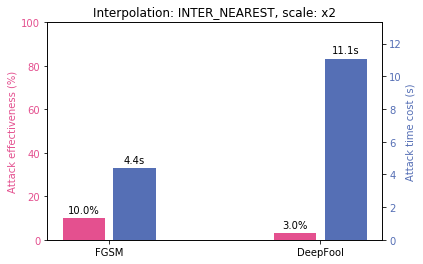

In [89]:
# get longest duration for attack to complete
longest_time_used = 0
for key in time_elapsed_dict:
  if time_elapsed_dict[key] > longest_time_used:
    longest_time_used = time_elapsed_dict[key]

# Plot statistics
x_labels = [method for method in means_of_attack]
x = np.arange(len(x_labels))
width = 0.2
fig, ax1 = plt.subplots(sharey=False)
rect_acc = ax1.bar(x - width / 2 - 0.02,
                   [attack_acc_dict[key] for key in attack_acc_dict],
                   width, label='Attack effectiveness', color='#e4508f')
ax1.set_xticks(x)
ax1.set_xticklabels(x_labels)
ax1.set_ylim(0, 100)
ax1.set_ylabel('Attack effectiveness (%)', color='#e4508f')
ax1.tick_params(axis='y', labelcolor='#e4508f')

ax2 = ax1.twinx()
rect_time = ax2.bar(x + width / 2 + 0.02,
                    [time_elapsed_dict[key] for key in time_elapsed_dict],
                    width, label='Cost of time', color='#556fb5')
ax2.set_ylim(0, longest_time_used * 1.2)
ax2.set_ylabel('Attack time cost (s)', color='#556fb5')
ax2.tick_params(axis='y', labelcolor='#556fb5')


def auto_label(ax, rects, unit=None):
  for rect in rects:
    height = rect.get_height()
    ax.annotate('{:.1f}{}'.format(height, unit),
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')


auto_label(ax1, rect_acc, unit='%')
auto_label(ax2, rect_time, unit='s')
plt.title(manipulation_method)
plt.show()
